In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sacc

#### Contact Andrew Liu via Email / Slack if you don't have access to the Sacc file for power spectra and covariance. CMB templates are in the `./cmb_templates/` directory.

In [14]:
def trj2tcmb(freq):
    x = 6.62607015e-34 * freq * 1e9 / 2.725 / 1.380649e-23
    return (np.exp(x) - 1)**2 / x**2 / np.exp(x)


def tcmb2trj(freq):
    x = 6.62607015e-34 * freq * 1e9 / 2.725 / 1.380649e-23
    return x**2 * np.exp(x) / (np.exp(x) - 1)**2


def planck_law(T, nu):
    # in RJ unit (not flux so no nu**3)
    # fac = 2 * 6.626e-34 / (3e8)**2
    expo = 6.62607015e-34 * nu * 1e9 / 1.380649e-23 / T
    return nu / (np.exp(expo) - 1)


def generate_ell_infos(lmax):
    """ create commonly used ell info (ell, cl2dl, dl2cl) """
    ell = np.arange(lmax + 1)
    cl2dl = ell * (ell + 1) / 2 / np.pi
    cl2dl[:2] = 0
    dl2cl = np.zeros_like(cl2dl)
    dl2cl[2:] = 1 / cl2dl[2:]
    return ell, cl2dl, dl2cl


def dust_power_spec(
    lmax,
    nu1,
    nu2=None,
    amp_d_bb=28.,
    alpha_d_bb=-0.16,
    beta_d=1.6,
    T_d=20.,
    nu0=353.,
    return_dell=True
):
    nu2 = nu1 if nu2 is None else nu2
    ell, c2d, d2c = generate_ell_infos(lmax)
    piv_ps = np.zeros_like(d2c)
    piv_ps[2:] = amp_d_bb * (ell[2:] / 80.)**alpha_d_bb
    if not return_dell:
        piv_ps *= d2c
    piv_ps *= tcmb2trj(nu0)**2
    scale = ((nu1 / nu0)**beta_d * (planck_law(T_d, nu1) / planck_law(T_d, nu0))) \
        * ((nu2 / nu0)**beta_d * (planck_law(T_d, nu2) / planck_law(T_d, nu0)))
    piv_ps *= scale * trj2tcmb(nu1) * trj2tcmb(nu2)
    return piv_ps


def sync_power_spec(
    lmax,
    nu1,
    nu2=None,
    amp_s_bb=5.,
    alpha_s_bb=1.5,
    beta_s=-3.,
    nu0=23.,
    return_dell=True
):
    nu2 = nu1 if nu2 is None else nu2
    ell, c2d, d2c = generate_ell_infos(lmax)
    piv_ps = np.zeros_like(d2c)
    piv_ps[2:] = amp_s_bb * (ell[2:] / 80.)**alpha_s_bb
    if not return_dell:
        piv_ps *= d2c
    piv_ps *= tcmb2trj(nu0)**2
    scale = ((nu1 / nu0)**beta_s) * ((nu2 / nu0)**beta_s)
    piv_ps *= scale * trj2tcmb(nu1) * trj2tcmb(nu2)
    return piv_ps


def cmb_power_spec(
    lmax,
    alens=1.,
    r=0.12,
    ltmp_path="cmb_templates/camb_lens_nobb.dat",
    rtmp_path="cmb_templates/camb_lens_r1.dat",
    return_dl=True
):
    
    ltmp = np.loadtxt(ltmp_path)
    ltmp_dl = np.concatenate((np.zeros((1,5)), ltmp), axis=0)[:lmax + 1]
    rtmp = np.loadtxt(rtmp_path)
    rtmp_dl = np.concatenate((np.zeros((1,5)), rtmp), axis=0)[:lmax + 1]
    ell = ltmp_dl[:, 0]
    ltmp_bb = ltmp_dl[:, 3]
    rtmp_bb = rtmp_dl[:, 3]
    
    if not return_dl:
        d2c = np.zeros_like(ltmp_bb)
        d2c[2:] = 2 * np.pi / ell[2:] / (ell[2:] + 1)
        ltmp_bb *= d2c
        rtmp_bb *= d2c
    
    lbb = alens * ltmp_bb
    rbb = r * (rtmp_bb - ltmp_bb)
    return lbb, rbb

In [15]:
# Put template parameters here
dust_kwargs = {"amp_d_bb": 21.50, "alpha_d_bb": -0.194, "beta_d": 1.614, "T_d": 19.6}
sync_kwargs = {"amp_s_bb": 2.83, "alpha_s_bb": 1.713, "beta_s": -2.861}
cmb_kwargs = {'alens':1., 'r':0.12}
nu = 90. # put template frequency here.

# generate CMB, and FG templates
lmax = 350
tplt_lmin = 2
tplt_lmax = 350
sls = slice(tplt_lmin, tplt_lmax + 1)

ell = np.arange(lmax + 1)
tplt_mask = (ell >= tplt_lmin) * (ell <= tplt_lmax)

dl_d = dust_power_spec(lmax, nu, **dust_kwargs)
dl_s = sync_power_spec(lmax, nu, **sync_kwargs)
dl_l, dl_r = cmb_power_spec(lmax, **cmb_kwargs)

In [16]:
# Pick the tracer (name of freq channel) INDEX you want to see
# You may pick 0, 0 first to see options before changing
i, j = 1, 1

cl_coadd = sacc.Sacc.load_fits("/scratch/gpfs/yl9946/e2e_vis/cl_and_cov_sacc_rotated.fits")
tracers = list(cl_coadd.tracers.keys())
print("Options (index : name)")
for k in range(tracers.__len__()):
    print("\t", k, ":", tracers[k]) # this will print all channels
    
print("Your Picks:")
print(i, tracers[i])
print(j, tracers[j])

# read data and covariance
data_lmin = 30.
data_lmax = 300.

e_l, data = cl_coadd.get_ell_cl("cl_bb", tracers[i], tracers[j])
e_c2d = e_l * (e_l + 1) / 2 / np.pi
cov_ind = cl_coadd.indices('cl_bb', (tracers[i], tracers[j]))
var = cl_coadd.covariance.covmat[cov_ind][:, cov_ind].diagonal()
msk = (e_l >= data_lmin) * (e_l <= data_lmax)

Options (index : name)
	 0 : SATp3_f150_south_science
	 1 : SATp3_f090_south_science
	 2 : wmap_f023_filtered_SATp3_f023
	 3 : planck_f030_filtered_SATp3_f090_south_science
	 4 : planck_f100_filtered_SATp3_f090_south_science
	 5 : planck_f143_filtered_SATp3_f090_south_science
	 6 : planck_f217_filtered_SATp3_f090_south_science
	 7 : planck_f353_filtered_SATp3_f090_south_science
Your Picks:
1 SATp3_f090_south_science
1 SATp3_f090_south_science


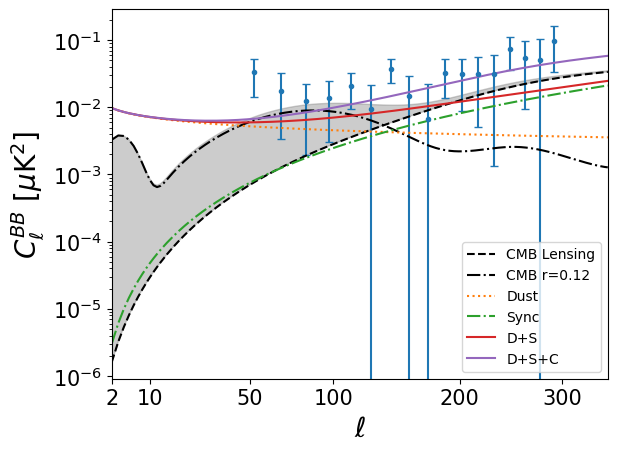

In [17]:
# plotting all components
plt.errorbar(e_l[msk], (data * e_c2d)[msk], (var * e_c2d**2)[msk]**.5, ls='', capsize=3, marker='.')
plt.plot(ell[sls], dl_l[sls], c='k', ls='--', label='CMB Lensing')
plt.plot(ell[sls], dl_r[sls], c='k', ls='-.', label=f'CMB r={cmb_kwargs['r']}')
plt.plot(ell[sls], dl_d[sls], c='tab:orange', ls=':', label='Dust')
plt.plot(ell[sls], dl_s[sls], c='tab:green', ls='-.', label='Sync')
plt.fill_between(ell, dl_l, (dl_l + dl_r), color='gray', alpha=.4)
plt.plot(ell[sls], (dl_s + dl_d)[sls], c='tab:red', label='D+S')
plt.plot(ell[sls], (dl_s + dl_d + dl_l)[sls], c='tab:purple', label='D+S+C')

# formatting
plt.yscale('log')
lpow = 0.6
plt.xlim(tplt_lmin, tplt_lmax)
plt.xscale('function', functions=(lambda x: x**lpow, lambda x: x**(1/lpow)))
xticks = np.array((2, 10, 50, 100, 200, 300))
xtick_labels = [f"{i}" for i in xticks]
plt.xticks(ticks=xticks, labels=xtick_labels, fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel(r"$\ell$", fontsize=20)
plt.ylabel(r"$C_\ell^{BB}$ [$\mu$K$^2$]", fontsize=20)
plt.legend()